In [226]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from config import config
import pickle
import shap
import polars as pl

In [227]:
def get_data():
    # se toma archivo pickle, si no existe se crea desde el csv generado en el script de R
    df = pd.read_csv('../data/vdem_coup_ML.csv')
    df = df[df['year']>=1970]
    # drop non numeric columns for df pandas dataframe
    df = df.select_dtypes(include=['number'])
    df = df[df.columns[~df.columns.str.startswith('e_')]]

    # divido en X e y
    X = df.drop(columns='coup')
    y = df.set_index('year')['coup']
    return X, y, df


In [228]:
X,y, df = get_data()

In [4]:
def score(modelo,anio1):
    dic = {}
    
    # se toma información del modelo desde el config file
    if modelo=='XGB':
        output = 'modelos/'+str(anio1)+'/xgboost.pkl'
    else:
        output = 'modelos/'+str(anio1)+'/random_forest.pkl'

    # cargamos modelo ya entrenado
    with open(output, 'rb') as f:
        clf = pickle.load(f)

    anios = range(anio1,2024)
    
    dic['AUC'] = pd.DataFrame(index=anios)

    for anio2 in anios:
        X_test, y_test           = X[X['year'] == anio2], y[y.index == anio2]
        X_test_acum, y_test_acum = X[X['year'].between(anio1,anio2)], y[(y.index>=anio1) & (y.index<=anio2)]
        
        y_pred = clf.predict(X_test)
                    
        y_pred_acum = clf.predict(X_test_acum)
        
        dic['AUC'].loc[anio2,'AUC'] = roc_auc_score(y_test, y_pred)
        dic['AUC'].loc[anio2,'AUC acumulada'] = roc_auc_score(y_test_acum, y_pred_acum)
    
    return dic

In [5]:
modelos = {}
for anio in range(2020,2024):
    modelos[anio] = {}
    modelos[anio]['RF'] = score('RF',anio)
    modelos[anio]['XGB'] = score('XGB',anio)

In [6]:
def reporte(anio):
    return    pd.concat((modelos[anio]['XGB']['AUC'],
                         modelos[anio]['RF']['AUC']),
                        axis=1,keys=['XGBoost','Random Forest'])

In [14]:
reporte(2020)

XGBoost               Random Forest              
           AUC AUC acumulada           AUC AUC acumulada
2020  1.000000      1.000000      1.000000      1.000000
2021  0.750000      0.785714      0.747110      0.784290
2022  0.666667      0.750000      0.666667      0.749051
2023  0.666667      0.730769      0.666667      0.730058

In [8]:
pd.concat((reporte(2021), reporte(2022), reporte(2023)),axis=0)

XGBoost               Random Forest              
           AUC AUC acumulada           AUC AUC acumulada
2021  0.750000      0.750000      0.747110      0.747110
2022  0.666667      0.722222      0.666667      0.720790
2023  0.666667      0.708333      0.833333      0.749048
2022  0.666667      0.666667      0.666667      0.666667
2023  0.663826      0.665246      0.833333      0.750000
2023  0.663826      0.663826      0.833333      0.833333

# Análisis individual de modelo

In [15]:
with open('modelos/2020/random_forest.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('modelos/2020/xgboost.pkl', 'rb') as f:
    xgb = pickle.load(f)

In [360]:
import json
with open('../data/country_codes.json',encoding='utf-8') as f:
    country_codes = json.load(f)

In [19]:
# X,y, df = get_data()

X_test  = X[X['year'].between(2020,2022)]
y_test  = y[(y.index>=2020) & (y.index<=2022)]
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

## Matriz de confusión

In [361]:
resultados = df.loc[df['year'].between(2020,2022),['country_id','year','coup']]

resultados['random forest'] = y_pred_rf
resultados['xgboost']    = y_pred_xgb

resultados['country_name'] = resultados['country_id'].astype(str).map(country_codes)


# replace coup and coup_pred with 'si' and 'no'
resultados['coup'] = resultados['coup'].replace({1:'Sí',0:'No'})
resultados['random forest'] = resultados['random forest'].replace({1:'Sí',0:'No'})
resultados['xgboost'] = resultados['xgboost'].replace({1:'Sí',0:'No'})

resultados.loc[(resultados['random forest']=='Sí')&(resultados['coup']=='Sí'),'random forest'] = 'Verdadero positivo'
resultados.loc[(resultados['random forest']=='Sí')&(resultados['coup']=='No'),'random forest'] = 'Falso positivo'
resultados.loc[(resultados['random forest']=='No')&(resultados['coup']=='No'),'random forest'] = 'Verdadero negativo'
resultados.loc[(resultados['random forest']=='No')&(resultados['coup']=='Sí'),'random forest'] = 'Falso negativo'

resultados.loc[(resultados['xgboost']=='Sí')&(resultados['coup']=='Sí'),'xgboost'] = 'Verdadero positivo'
resultados.loc[(resultados['xgboost']=='Sí')&(resultados['coup']=='No'),'xgboost'] = 'Falso positivo'
resultados.loc[(resultados['xgboost']=='No')&(resultados['coup']=='No'),'xgboost'] = 'Verdadero negativo'
resultados.loc[(resultados['xgboost']=='No')&(resultados['coup']=='Sí'),'xgboost'] = 'Falso negativo'

TP_RF = (resultados['random forest'] == 'Verdadero positivo')
TP_XGB = (resultados['xgboost'] == 'Verdadero positivo')
FP_RF = (resultados['random forest'] == 'Falso positivo')
FP_XGB = (resultados['xgboost'] == 'Falso positivo')
TN_RF = (resultados['random forest'] == 'Verdadero negativo')
TN_XGB = (resultados['xgboost'] == 'Verdadero negativo')
FN_RF = (resultados['random forest'] == 'Falso negativo')
FN_XGB = (resultados['xgboost'] == 'Falso negativo')

In [364]:
resultados.loc[TP_RF|TP_XGB|FP_RF|FP_XGB|FN_RF|FN_XGB,['country_name','year','coup','random forest','xgboost']]\
    .sort_values(['year'])\
    .rename(columns={'country_name':'país','year':'año','coup':'¿Hubo golpe?','random forest':'Random Forest','xgboost':'xgboost'})


,país,año,¿Hubo golpe?,Random Forest,xgboost
1718,Malí,2020,Sí,Verdadero positivo,Verdadero positivo
589,Birmania/Myanmar,2021,Sí,Verdadero positivo,Verdadero positivo
1719,Malí,2021,Sí,Falso negativo,Falso negativo
2028,Sudán,2021,Sí,Verdadero positivo,Verdadero positivo
2202,Afganistán,2021,No,Falso positivo,Verdadero negativo
3929,Níger,2021,Sí,Falso negativo,Falso negativo
4151,Guinea,2021,Sí,Verdadero positivo,Verdadero positivo
7344,Chad,2021,Sí,Falso negativo,Falso negativo
3486,Burkina Faso,2022,Sí,Verdadero positivo,Verdadero positivo
8045,Guinea-Bisáu,2022,Sí,Falso negativo,Falso negativo


In [62]:
from plotnine import ggplot, aes, geom_bar, coord_flip
from plotnine import theme_minimal, scale_fill_cmap_d, theme_minimal
from plotnine import geom_label, theme, labs, theme, ggsave, element_rect, element_text, ggsave

## Probabilidades

In [365]:
def prob_plot(model):
    resultados['coup_prob'] = model.predict_proba(X_test)[:,1]
    proba = resultados[['country_name','year','coup_prob','coup']].rename(columns={'coup':'golpe'})
    proba['pais_año'] = proba['country_name'] + ' ' + proba['year'].astype(str)
    # resultados.loc[resultados['coup']=='No','pais_año'] = ''
    proba = proba.sort_values('coup_prob',ascending=False).head(25)
    # resultados.rename({'coup':'¿'})
    f = ggplot(proba)+aes(x='reorder(pais_año,coup_prob)',y='coup_prob',fill='golpe')+\
        geom_bar(stat='identity')+coord_flip()+\
        labs(x='',y='Probabilidad de golpe de estado')+\
        theme_minimal()+\
        theme(plot_background=element_rect(color='black'),
            plot_caption=element_text(size=7,alpha=.7))
    return f

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/6_prob_xgb.png


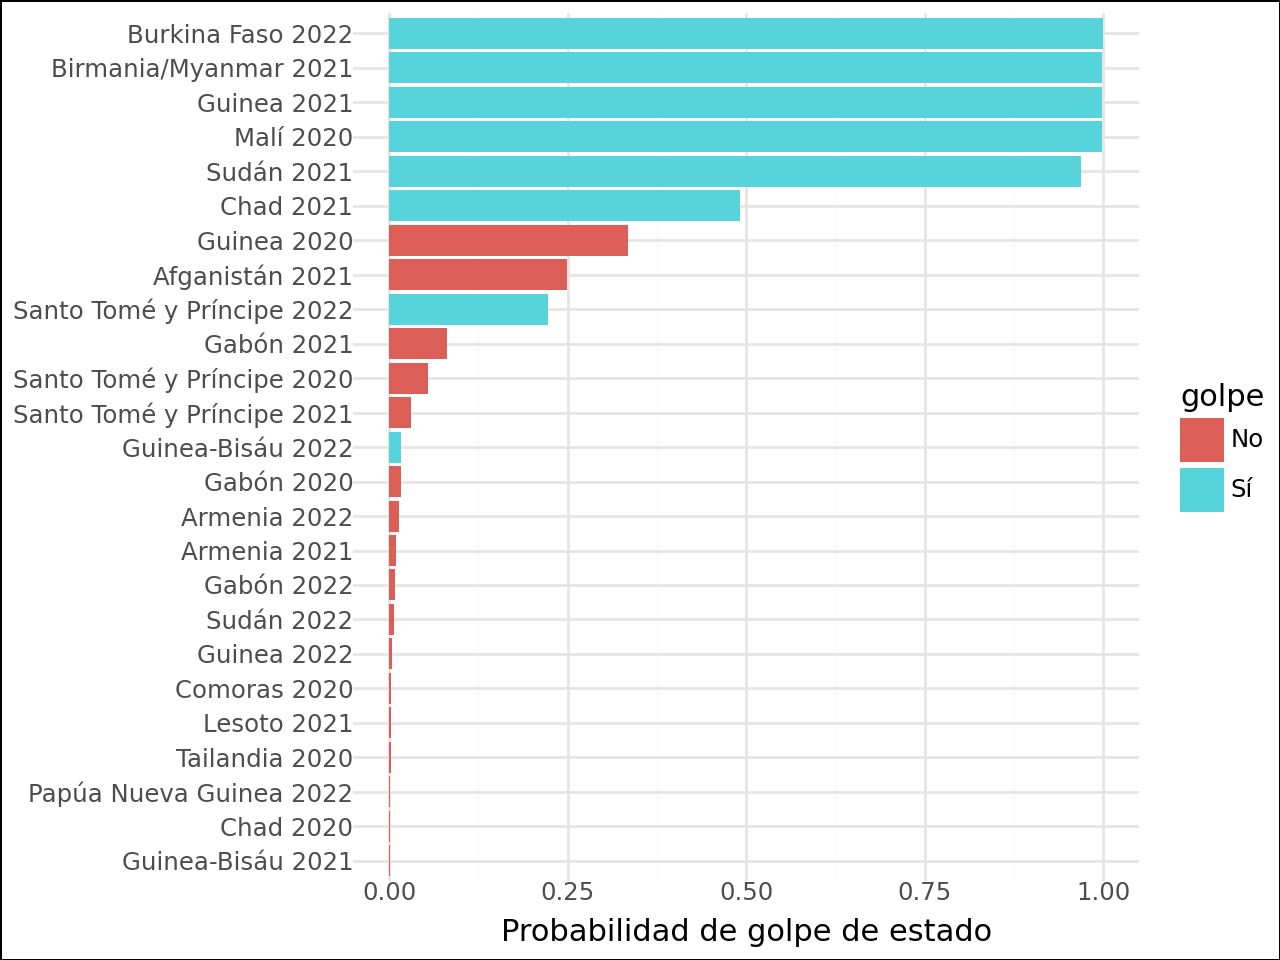

In [366]:
prob_xgb = prob_plot(xgb)
ggsave(prob_xgb,'../entregas/imagenes/6_prob_xgb.png',width=10,height=5)
prob_xgb

In [367]:
check = resultados.copy()
check['coup_prob_rf'] = rf.predict_proba(X_test)[:,1]
check['coup_prob_xgb'] = xgb.predict_proba(X_test)[:,1]

In [368]:
check = check.sort_values('coup_prob_rf',ascending=False).reset_index(drop=True)
check['top_rf'] = check.index+1
check = check.sort_values('coup_prob_xgb',ascending=False).reset_index(drop=True)
check['top_xgb'] = check.index+1

In [370]:
check[(check['country_name']=='Níger')&(check['year']==2021)].T

,43
country_id,60
year,2021
coup,Sí
random forest,Falso negativo
xgboost,Falso negativo
country_name,Níger
coup_prob,0.00033
coup_prob_rf,0.0446
coup_prob_xgb,0.00033
top_rf,36


c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/5_prob_rf.png


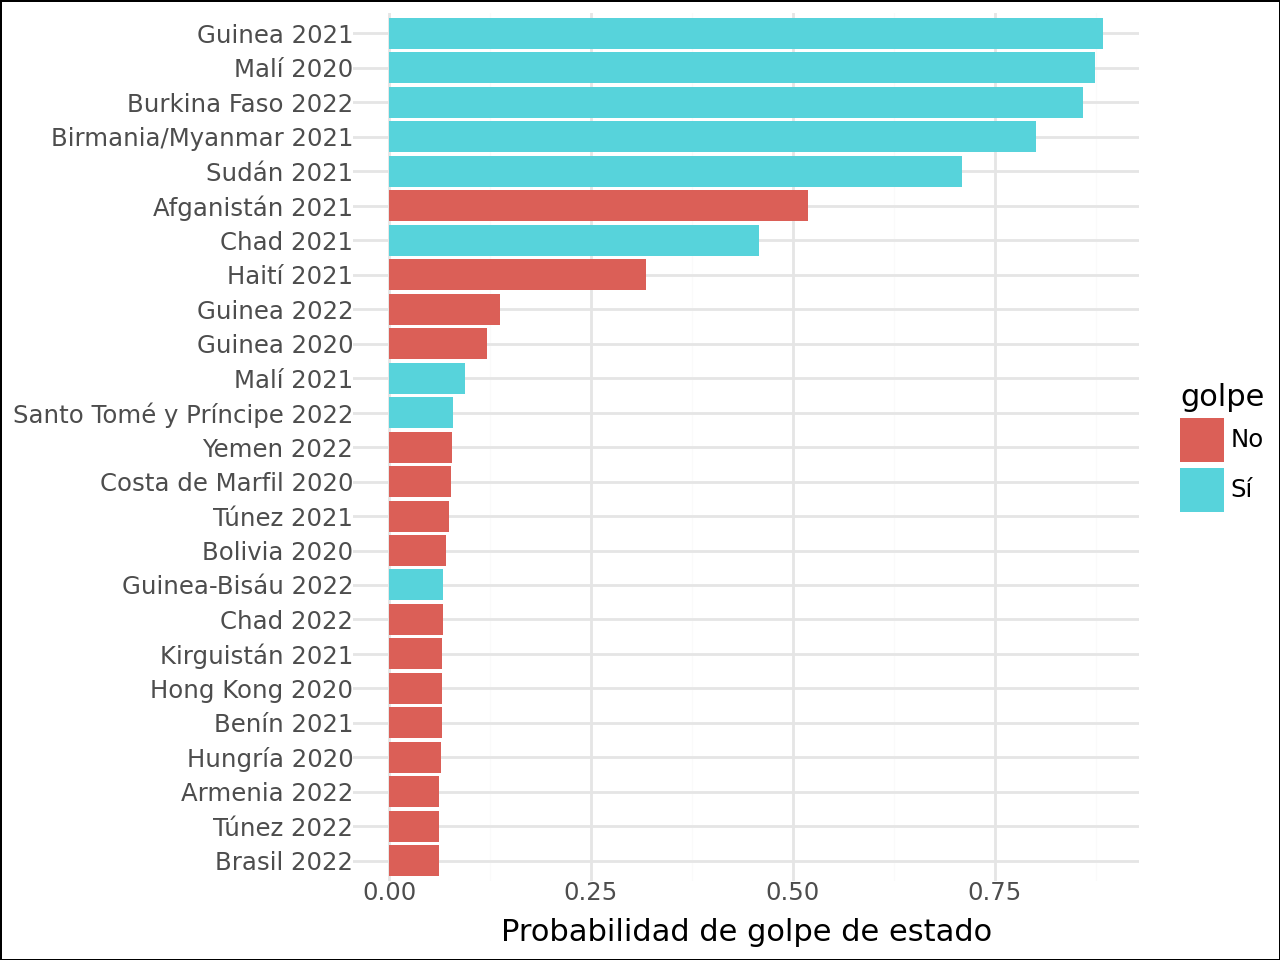

In [371]:
prob_rf = prob_plot(rf)
ggsave(prob_rf,'../entregas/imagenes/5_prob_rf.png',width=10,height=5)
prob_rf

## Importancia de variable

In [397]:
feat_imp_labs = {
'v2regdur'              :'Días desde\ncomienzo del régimen',
'v2regendtypems_0_lag_1':'¿El régimen terminó por\nun golpe de estado? (lag 1)*',
'v2x_hosinter'          :'¿El ejecutivo\nno es más electo?',
'v2xlg_leginter'        :'¿Legislatura\ncerrada o abortada?',
'v2regendtype_lag_1'    :'Proceso más importante para\nterminar con un régimen (lag 1)',
'v2x_ex_military'       :'Influencia de las FFAA\nsobre el Poder Ejecutivo',
'v2regoppgroupsact_5'   :'FFA se movilizan\ncontra el régimen?',
'coup_lag_1'            :'¿golpes de estado\nen el último año?',
'v2x_ex_military_lag_1' :'Influencia de las FFAA sobre\nel Poder Ejecutivo (lag 1)',
'v2expathhs'            :'¿Cómo llega el jefe\nde estado al gob?',
'v2regendtype_lag_5'    :'¿Qué proceso fue el más importante\nen el fin del régimen? (lag 5)*',
'v2clpolcl_lag_1'       :'Libertad para todos\nlos grupos sociales',
'v2csanmvch_2_lag_10'   :'Grupos antisistema que\nmezclan métodos\nlegales e ilegales (lag 10)',
'v2juhcind'             :'Decisiones importantes\nde la Corte Suprema\nalineadas con el gobierno',
'v2exfxtmhs_lag_1'      :'Duración máxima del mandato\ndel jefe de Estado (lag 1)',
# 'v2elrgpwr_lag_5'       :'Poder relativo entre miembros electos\ny no electos a nivel regional (lag 5)',
'v2edpoledprim_lag_5'   :'¿Se enseña en la primaria contenidos\ncon valores políticos? (lag 5)',
'v2elpeace'             :'Violencia durante\nperíodo electoral',
# 'v2elrgpwr_lag_10'      :'Poder relativo entre miembros electos\ny no electos a nivel regional (lag 10)',
'v2pesecsch'            :'Porcentaje de población\nen escuela secundaria',
'v2lgqugent'            :'Cuota femenina en la cámara baja\n(o cámara única)',
'v2ellostlg'            :'Bancas obtenidas por el partido\nmás grande\nen la última elección',
'v2casoe_1'             :'Emergencia nacional:\nno declarada pero medidas\npreparatorias tomadas',
'v2casoe_4'             :'Declaración de estado de\nemergencia nacional por\nconflicto armado',
'v2casoe_6'             :'Declaración de estado de\nemergencia nacional por\notros motivos',
'v2exagehos_lag_5'      :'Año de nacimiento del\njefe de estado (lag 5)',
'v2elvotbuy_lag_1'      :'¿Hubo evidencia de compra\nde votos en la última\nelección? (lag 1)',
'v2asuffrage'           :'Porcentaje de adultos con derecho\na votar mayores que la edad mínima'

}

In [238]:
anexo_val = pd.DataFrame(feat_imp_labs.values(),feat_imp_labs.keys())
anexo_val[0] = anexo_val[0].str.replace('\n',' ')
print(anexo_val.to_latex(escape=True))

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
v2regdur & Días desde comienzo del régimen \\
v2regendtypems\_0\_lag\_1 & ¿El régimen terminó por un golpe de estado? (lag 1)* \\
v2x\_hosinter & ¿El ejecutivo no es más electo? \\
v2xlg\_leginter & ¿Legislatura cerrada o abortada? \\
v2regendtype\_lag\_1 & Proceso más importante para terminar con un régimen (lag 1) \\
v2x\_ex\_military & Influencia de las FFAA sobre el Poder Ejecutivo \\
v2regoppgroupsact\_5 & FFA se movilizan contra el régimen? \\
coup\_lag\_1 & ¿golpes de estado en el último año? \\
v2x\_ex\_military\_lag\_1 & Influencia de las FFAA sobre el Poder Ejecutivo (lag 1) \\
v2expathhs & ¿Cómo llega el jefe de estado al gob? \\
v2regendtype\_lag\_5 & ¿Qué proceso fue el más importante en el fin del régimen? (lag 5)* \\
v2clpolcl\_lag\_1 & Libertad para todos los grupos sociales \\
v2csanmvch\_2\_lag\_10 & Grupos antisistema que mezclan métodos legales e ilegales (lag 10) \\
v2juhcind & Decisiones importantes de la Corte Suprema

In [398]:
def feature_imp(model,caption):

    # create a dataframe with feature importances and column name
    feat_imp = pd.DataFrame(zip(X.columns,model.feature_importances_), columns=['Variable','Importancia'])
    feat_imp.sort_values('Importancia',ascending=False,inplace=True)

    # feat_imp['Importancia acumulada'] = np.cumsum(feat_imp['Importancia'])
    # feat_imp = pd.merge(feat_imp,codebook_tag,how='left')

    tab_feat_imp = feat_imp[['Variable','Importancia']].sort_values('Importancia',ascending=False).drop_duplicates().head(7).reset_index(drop=True)
    tab_feat_imp['Importancia'] = tab_feat_imp['Importancia'].astype(float)
    tab_feat_imp['Variable ext'] = tab_feat_imp['Variable'].apply(lambda x: feat_imp_labs[x] if x in feat_imp_labs.keys() else x)
    tab_feat_imp.sort_values(by='Importancia',ascending=False).reset_index(drop = True)
    #para ordenar barras
    tab_feat_imp['Variable ext'] = pd.Categorical(tab_feat_imp['Variable ext'],categories=pd.unique(tab_feat_imp['Variable ext']))
    # tab_feat_imp['Importancia'] = tab_feat_imp['Importancia'].round(3)
    f = ggplot(tab_feat_imp)\
        + aes(x="Variable ext", y="Importancia")\
        + geom_bar(stat="identity",fill='#377eb8') + coord_flip()\
        + geom_label(aes(label='round(Importancia,3)'),size=7)\
        + scale_fill_cmap_d(cmap_name='viridis')\
        + labs(x='',y='Importancia de la variable',
            caption=caption)\
        + theme_minimal()\
        +theme(legend_position='none',plot_background=element_rect(color='black'),
            plot_caption=element_text(size=7,alpha=.7))
    return f


In [391]:
pd.DataFrame(zip(xgb.feature_importances_,X.columns)).sort_values(0,ascending=False).head(7)[0].sum()

0.13234453

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/7_feature_importance_rf.png


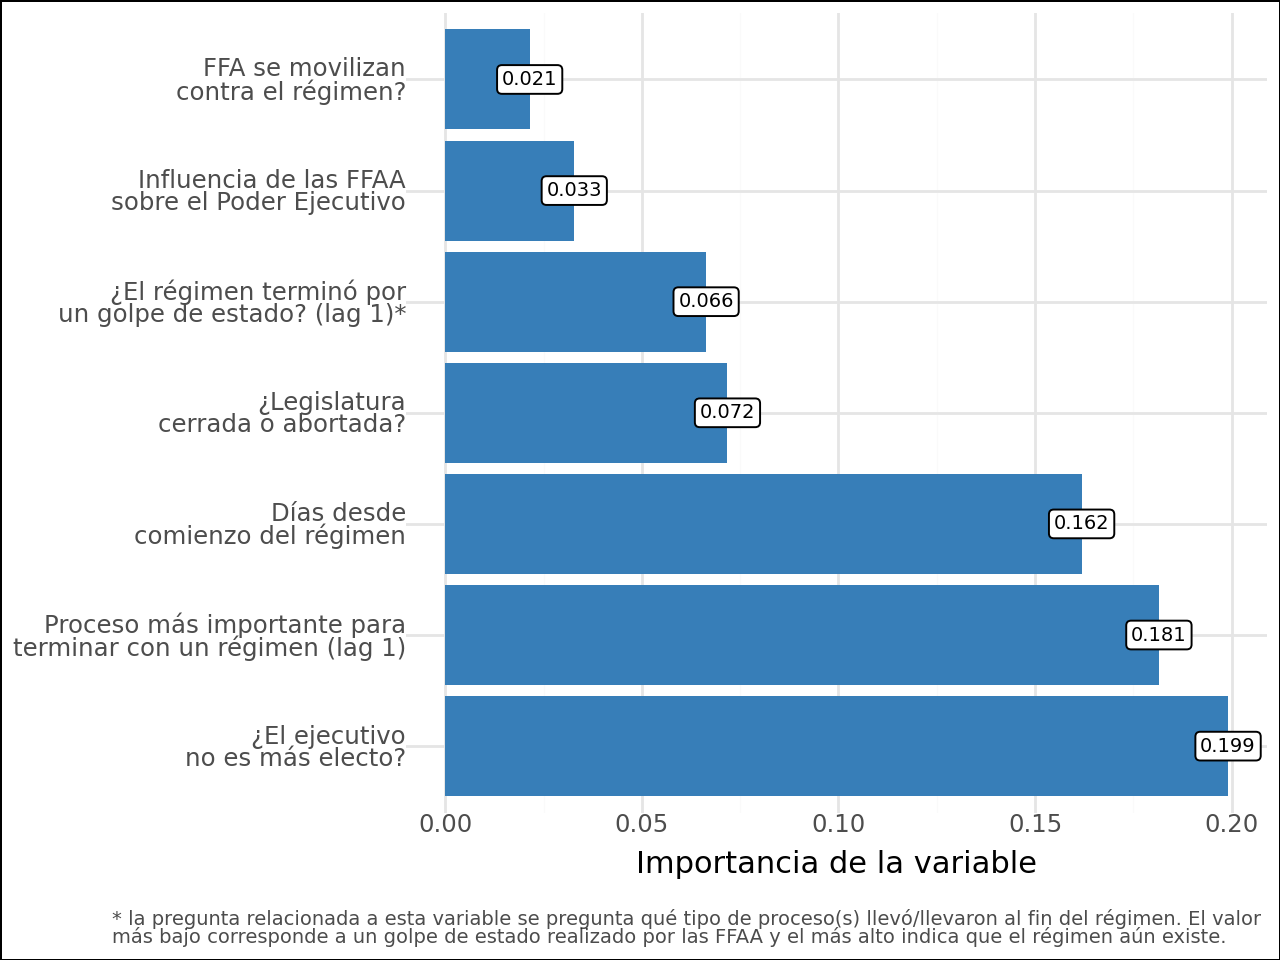

In [399]:
feat_imp_rf = feature_imp(rf,'''
    * la pregunta relacionada a esta variable se pregunta qué tipo de proceso(s) llevó/llevaron al fin del régimen. El valor 
    más bajo corresponde a un golpe de estado realizado por las FFAA y el más alto indica que el régimen aún existe.''')
ggsave(feat_imp_rf,'../entregas/imagenes/7_feature_importance_rf.png',width=6,height=4)
feat_imp_rf

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/8_feature_importance_xgb.png


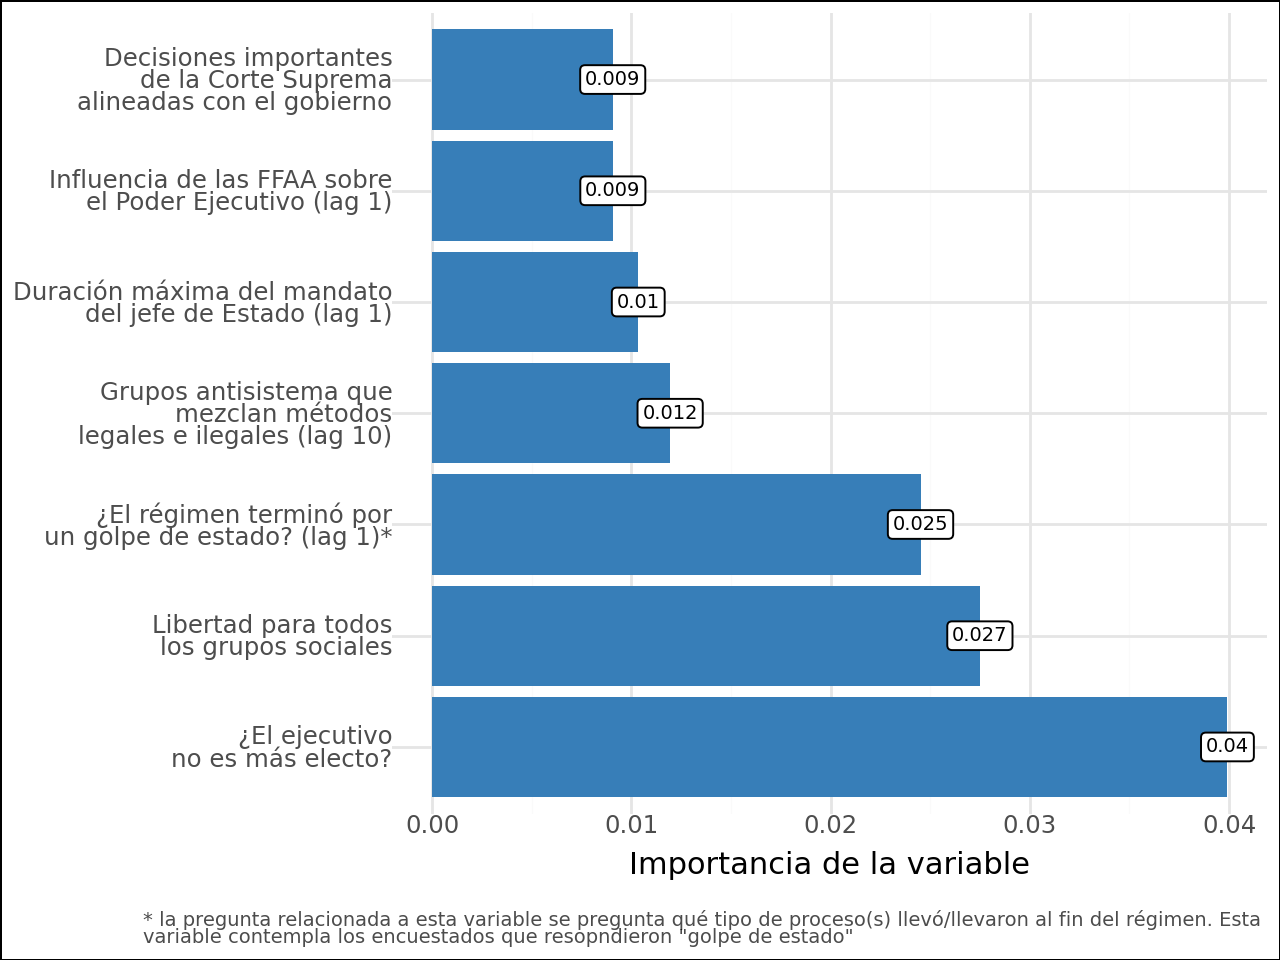

In [272]:

feat_imp_xgb = feature_imp(xgb,'''
    * la pregunta relacionada a esta variable se pregunta qué tipo de proceso(s) llevó/llevaron al fin del régimen. Esta 
    variable contempla los encuestados que resopndieron "golpe de estado"''')
ggsave(feat_imp_xgb,'../entregas/imagenes/8_feature_importance_xgb.png',width=6,height=4)
feat_imp_xgb

# Shapley values

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

In [307]:
def shapley_violin_plot(model,X):

    shap_values = shap.TreeExplainer(model).shap_values(X)

    X_imp_labs = X.columns.map(lambda x: feat_imp_labs[x] if x in feat_imp_labs.keys() else x)
    # Obtener la figura actual
    fig = plt.figure()
    # detect if model is a random forest
    if not hasattr(model,'booster'):       
        shap_values = shap_values[:,:,1]
        nombre = 'Random Forest'
    else:
        nombre = 'XGBoost'
    shap.violin_plot(shap_values, X,max_display=11,
                    feature_names=X_imp_labs,
                    plot_size=.7,show=False,
                    color_bar_label='Valor de la variable'
                    )

    plt.xlabel(f'Valor SHAP (Impacto en la salida del modelo {nombre})')

    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(2)
    
    return fig

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


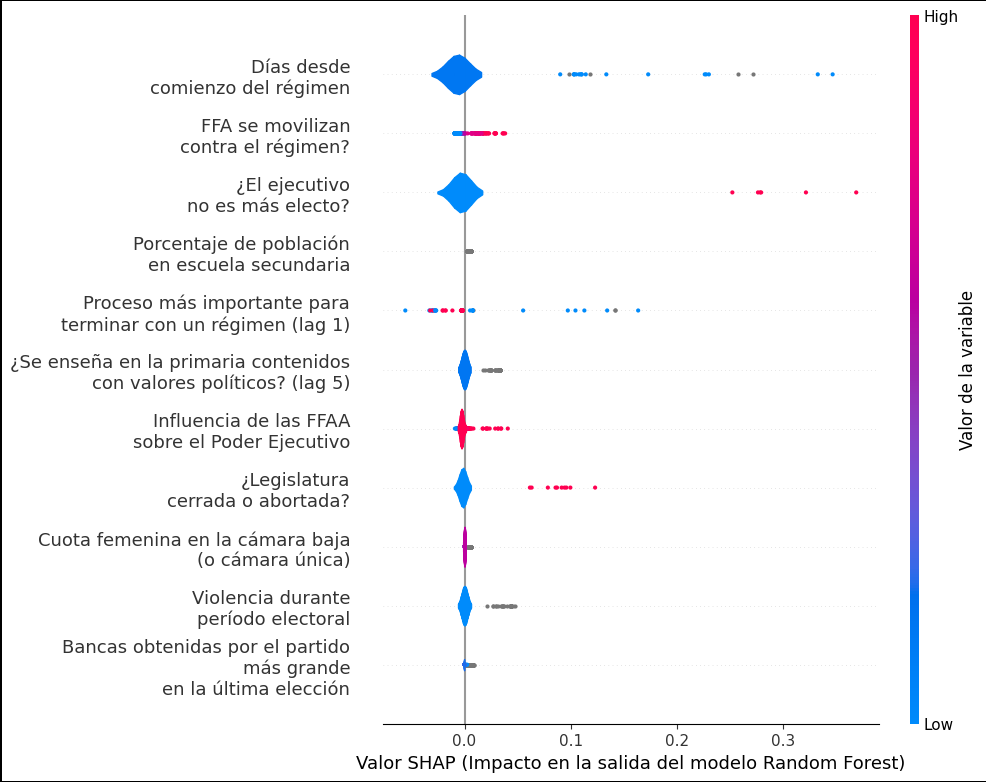

In [400]:
f = shapley_violin_plot(rf,X_test)
plt.savefig('../entregas/imagenes/9_shapley_values_rf.png',bbox_inches='tight',dpi=300)
f

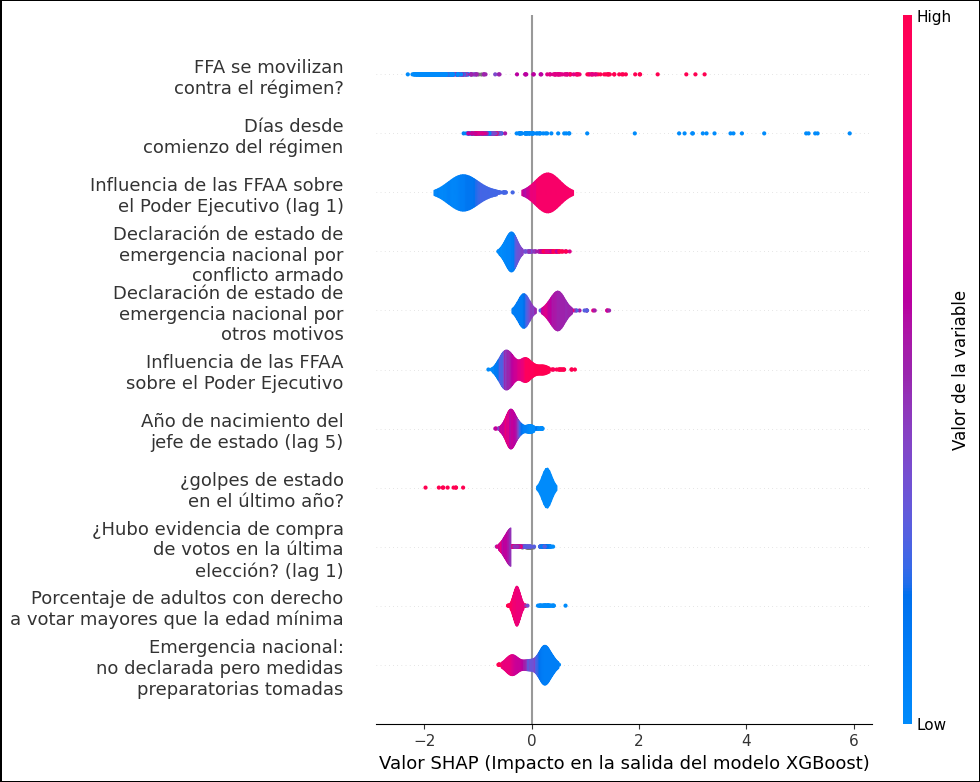

In [401]:
f = shapley_violin_plot(xgb,X_test)
plt.savefig('../entregas/imagenes/10_shapley_values_xgb.png',bbox_inches='tight',dpi=300)
f

### Año en particular

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


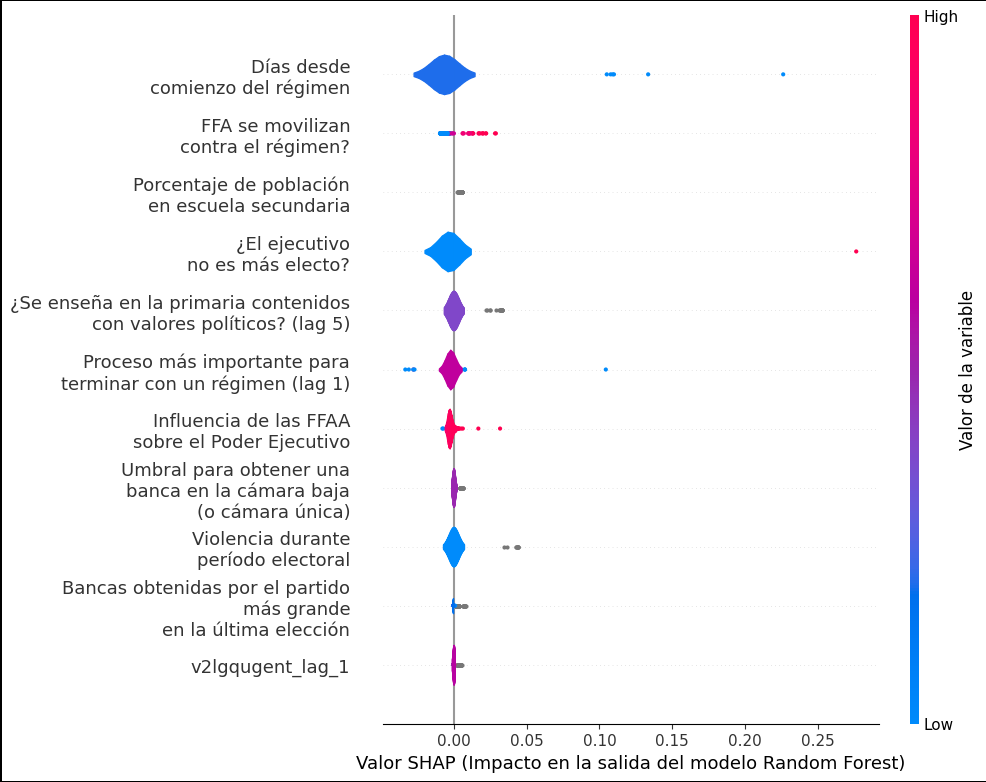

In [339]:
shapley_violin_plot(rf,X_test[X_test['year']==2020])

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


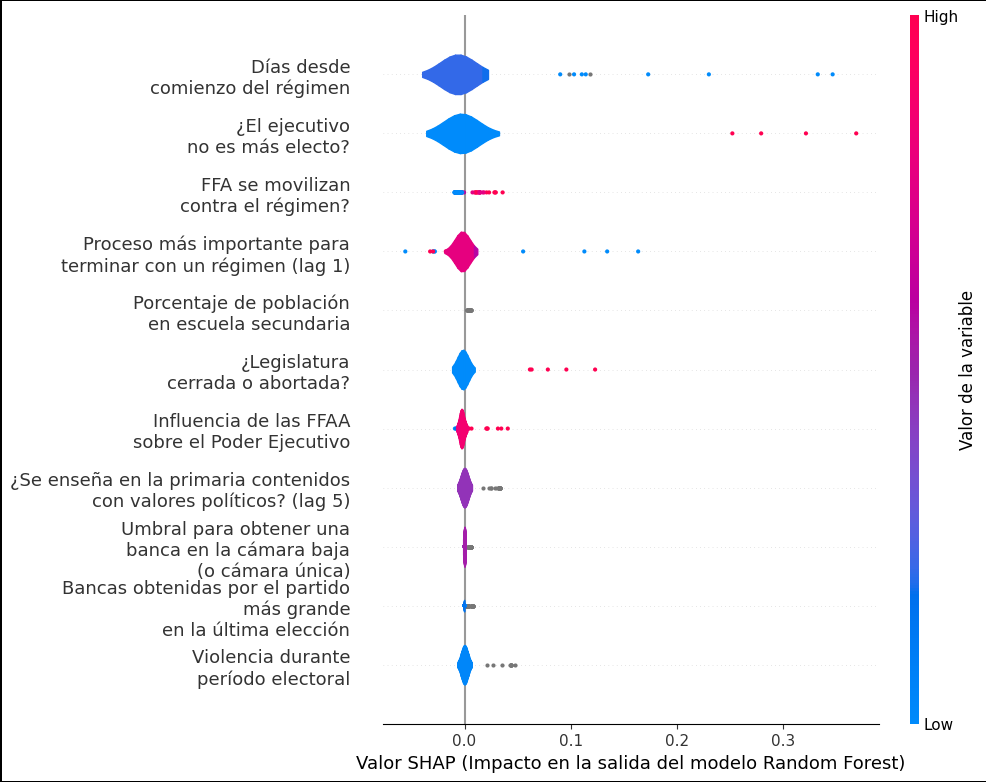

In [340]:
shapley_violin_plot(rf,X_test[X_test['year']==2021])

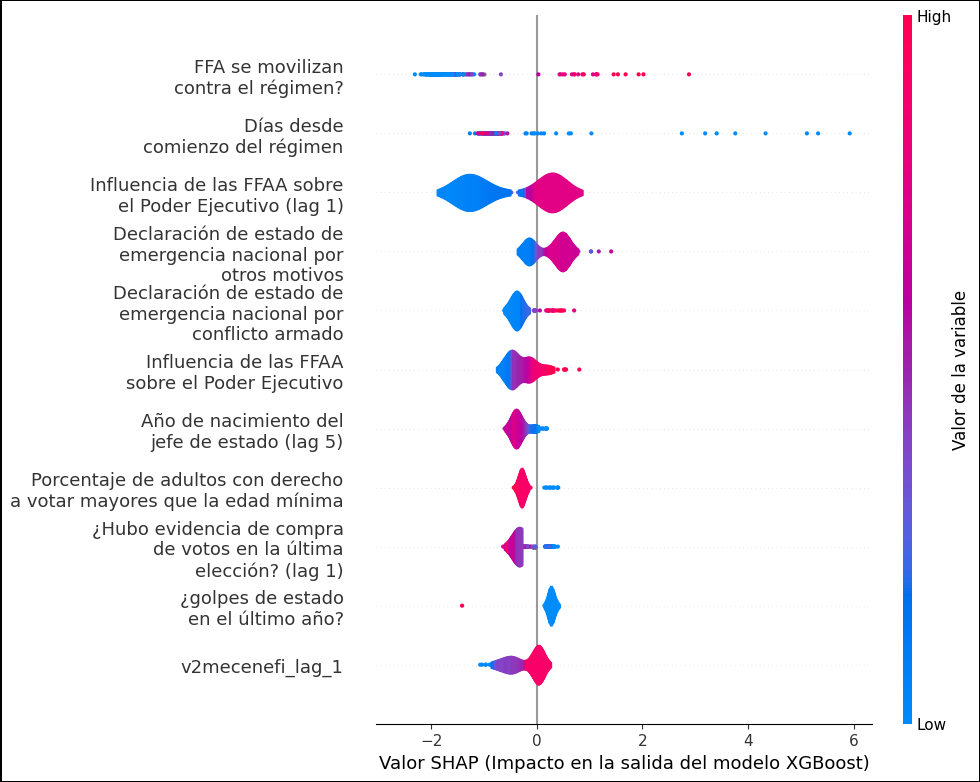

In [341]:
shapley_violin_plot(xgb,X_test[X_test['year']==2021])

### País en particular

In [328]:
def get_key(country_name):
    return int([k for k,v in country_codes.items() if v == country_name][0])

In [330]:
get_key('Niger')

60

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


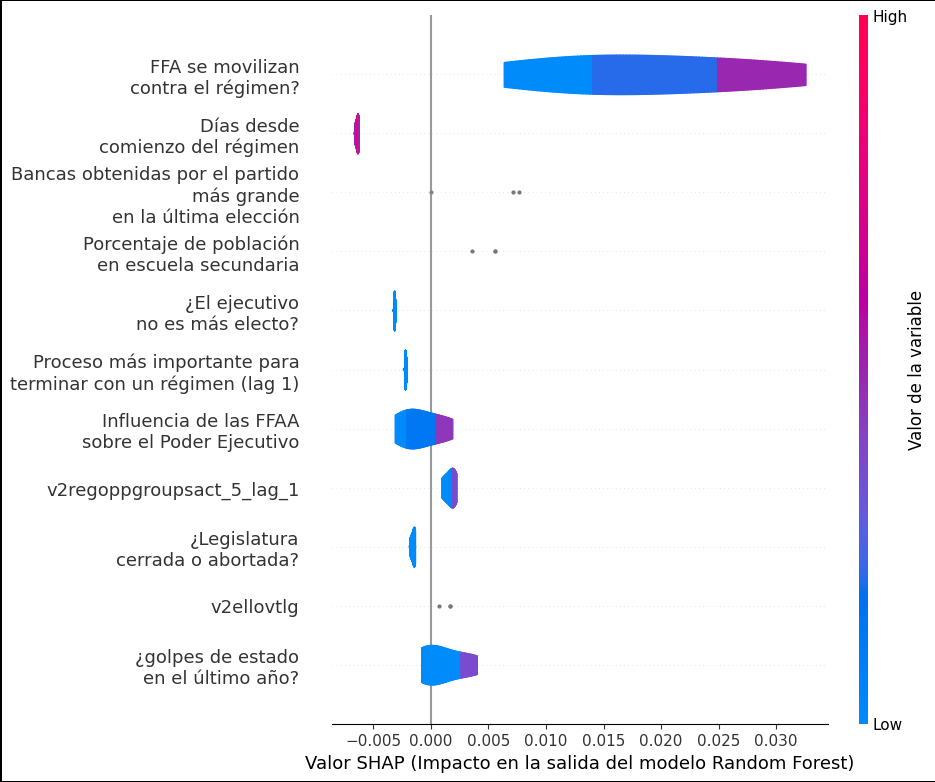

In [348]:
shapley_violin_plot(rf,X_test[(X_test['year']<2023)&(X_test['country_id']==get_key('Niger'))])

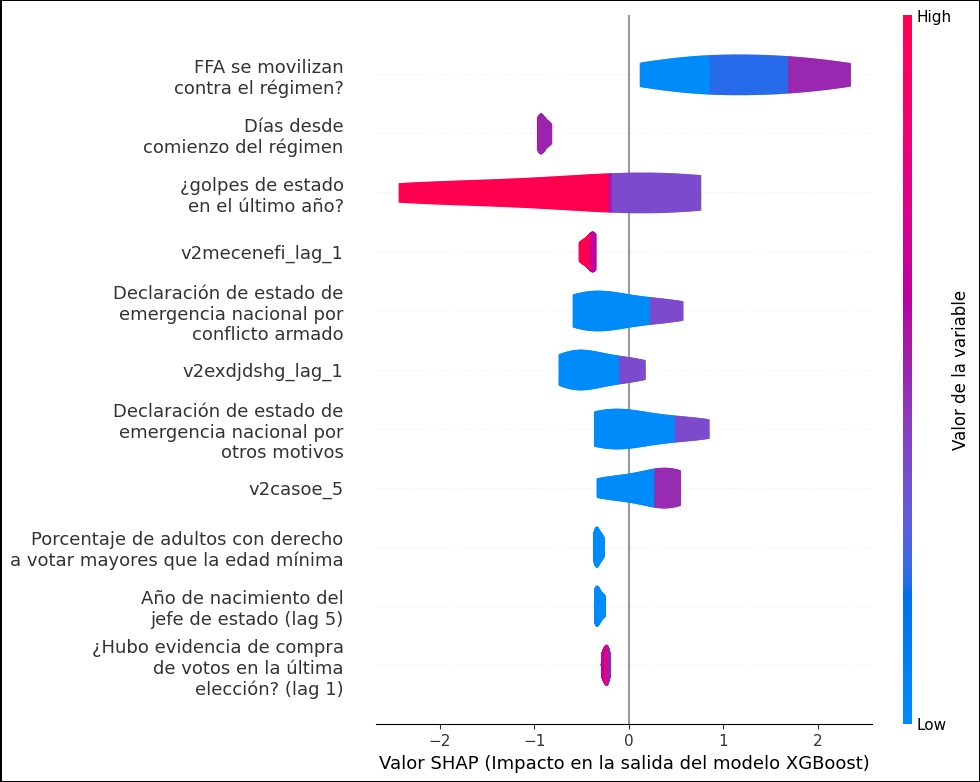

In [349]:
shapley_violin_plot(xgb,X_test[(X_test['year']<2023)&(X_test['country_id']==get_key('Niger'))])

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


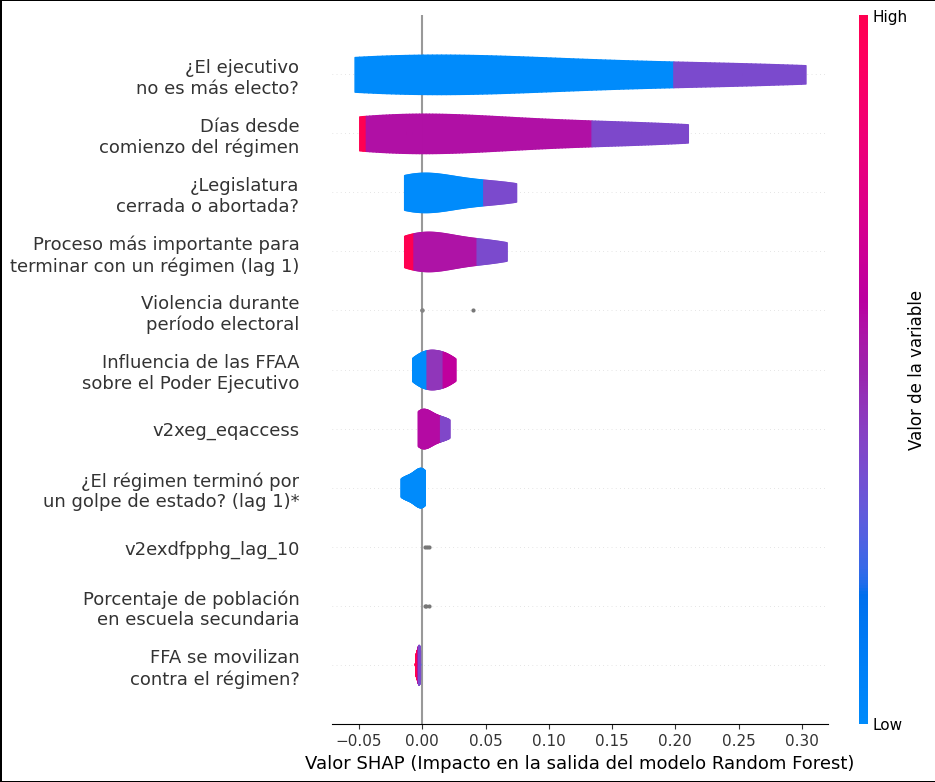

In [345]:
shapley_violin_plot(rf,X_test[(X_test['year']<2023)&(X_test['country_id']==get_key('Afghanistan'))])

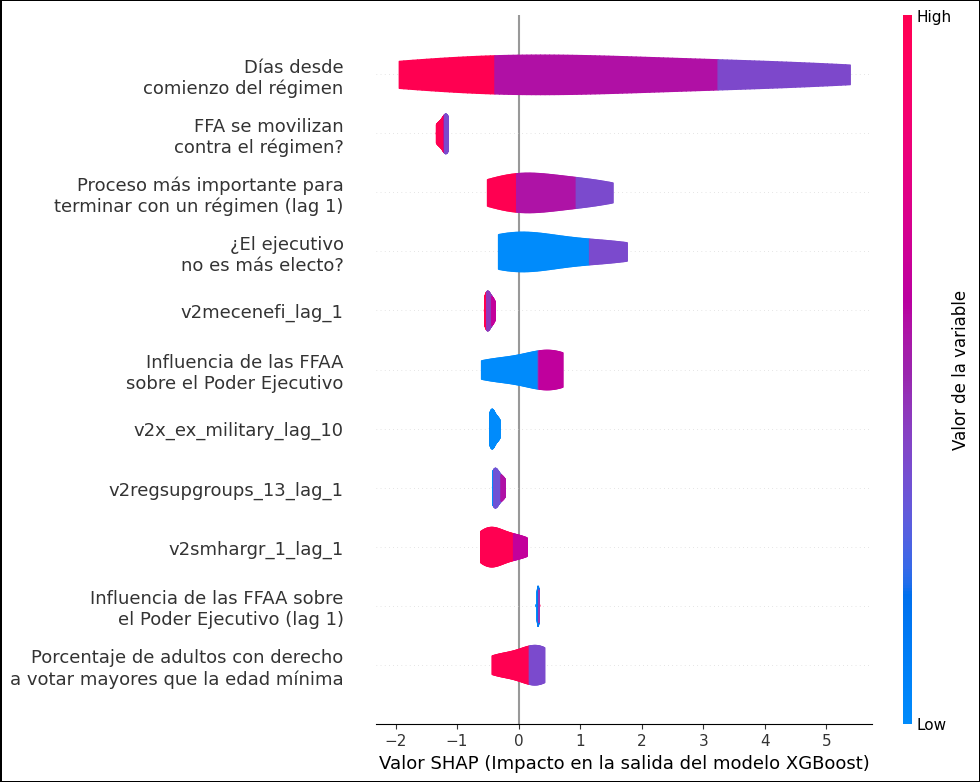

In [346]:
shapley_violin_plot(xgb,X_test[(X_test['year']<2023)&(X_test['country_id']==get_key('Afghanistan'))])

In [ ]:
for feat in feat_imp_labs.keys():
    fig = plt.figure()
    shap.dependence_plot(feat,shap_values_rf[:,:,1],X_test,interaction_index=feat)
    plt.ylabel('Valor SHAP (conribución a la predicción)')
    plt.xlabel(feat_imp_labs[feat])

<Figure size 640x480 with 0 Axes>

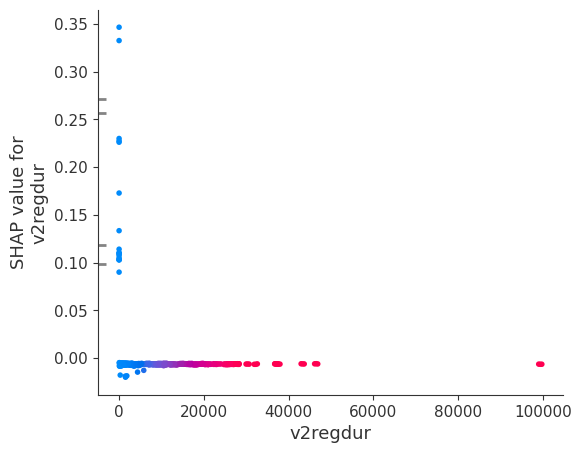

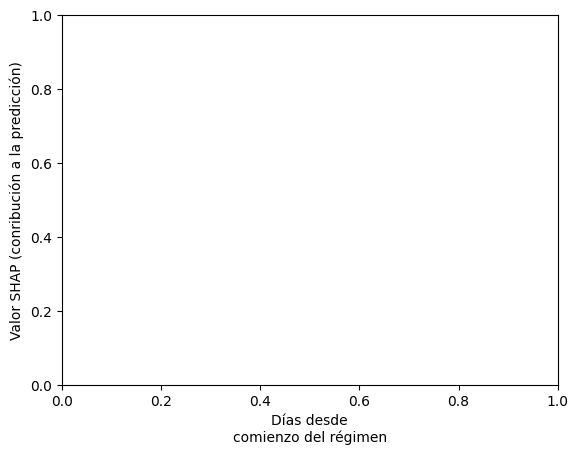

<Figure size 640x480 with 0 Axes>

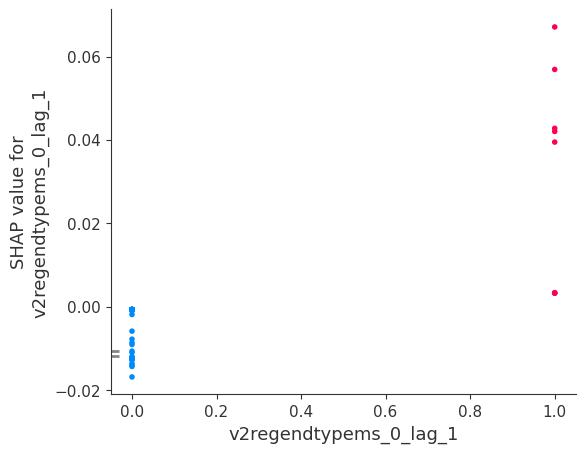

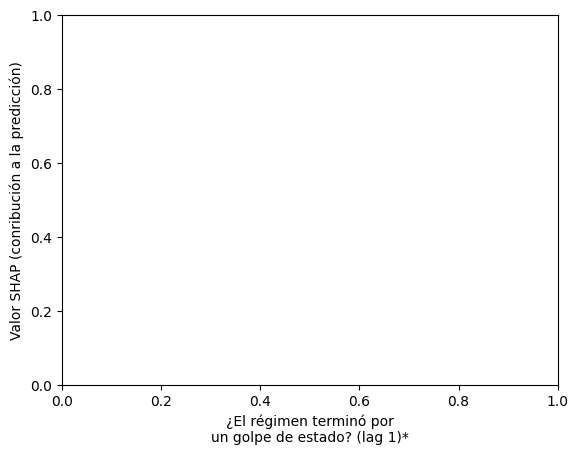

<Figure size 640x480 with 0 Axes>

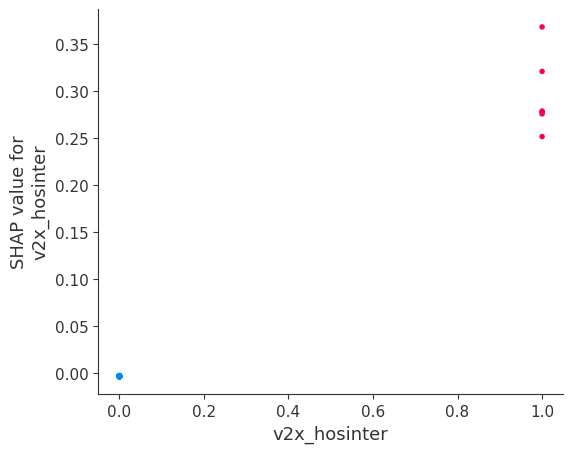

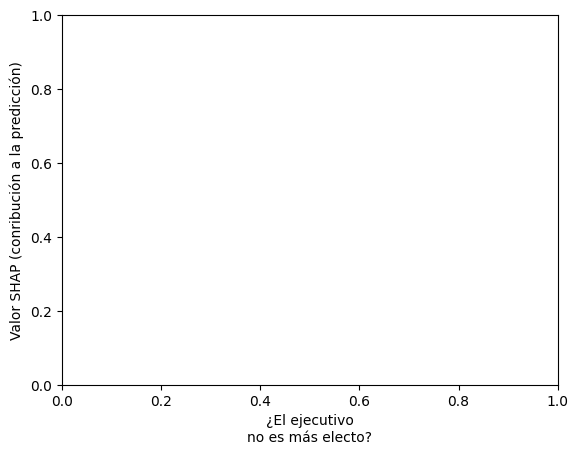

<Figure size 640x480 with 0 Axes>

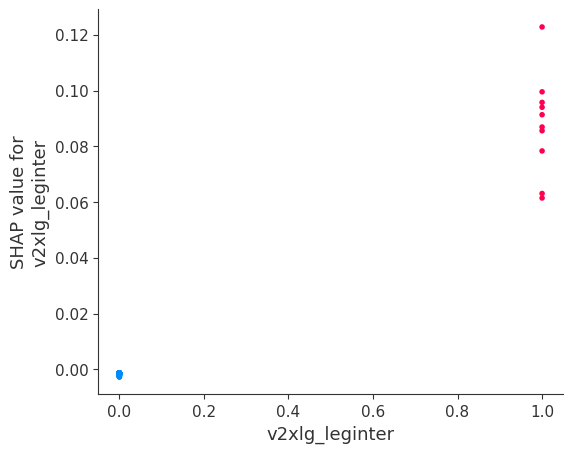

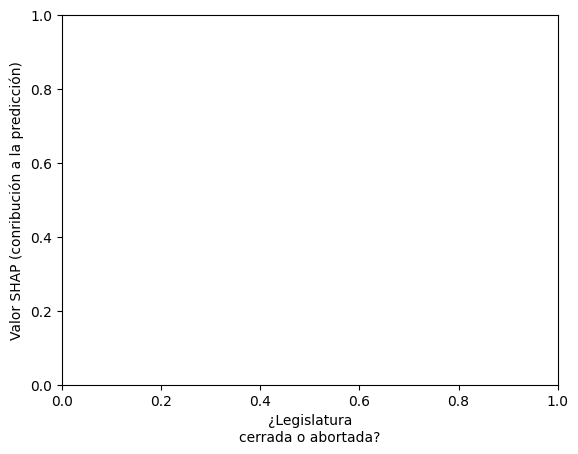

<Figure size 640x480 with 0 Axes>

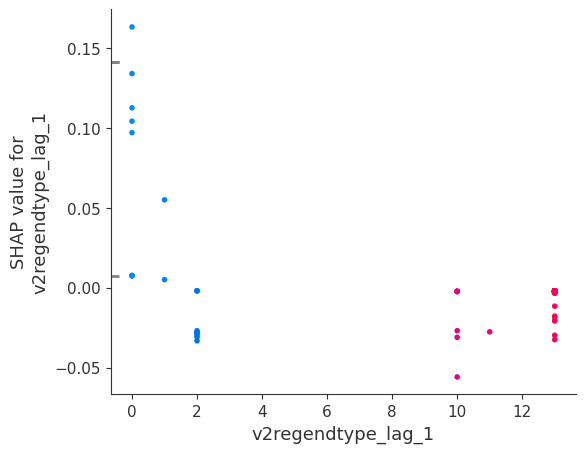

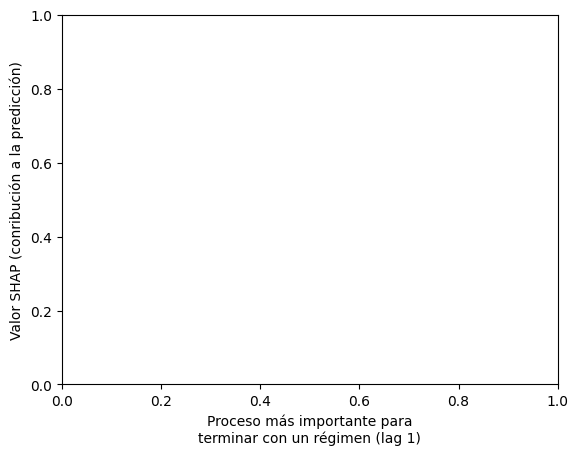

<Figure size 640x480 with 0 Axes>

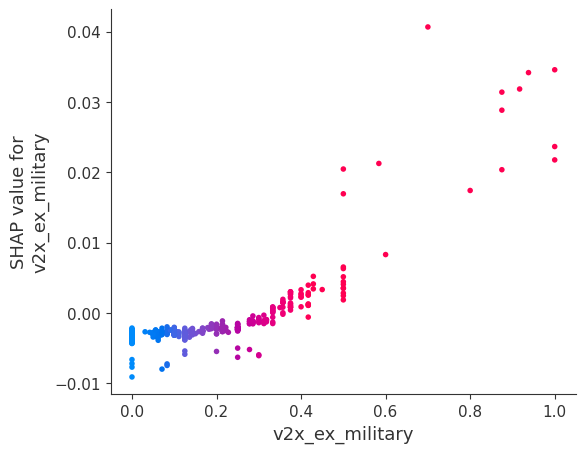

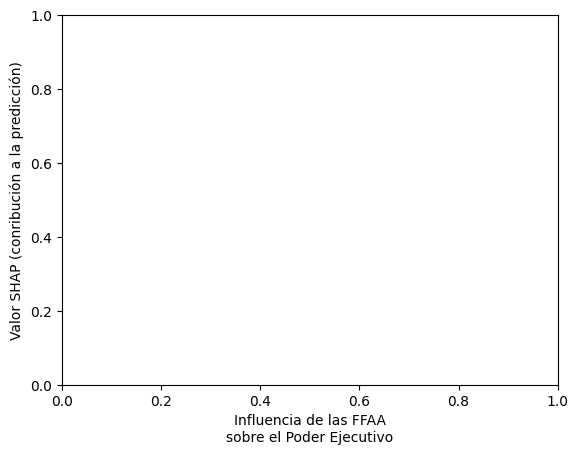

<Figure size 640x480 with 0 Axes>

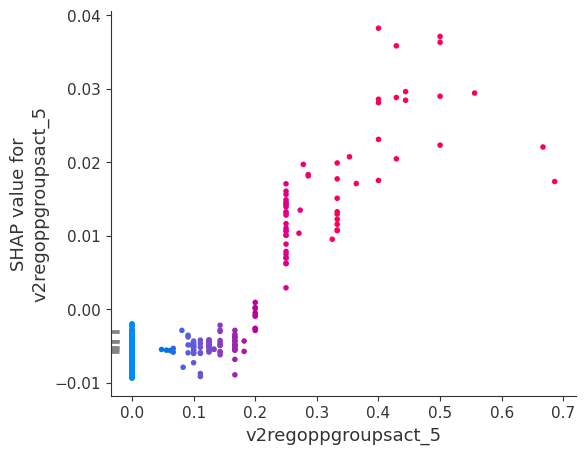

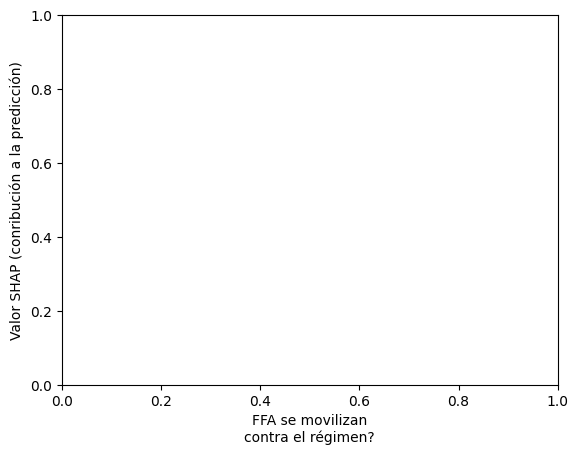

<Figure size 640x480 with 0 Axes>

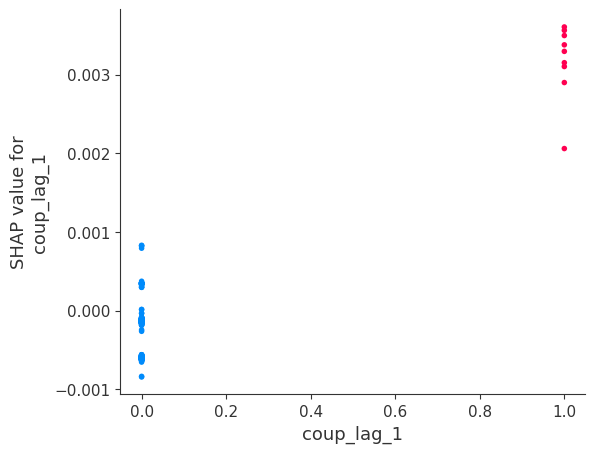

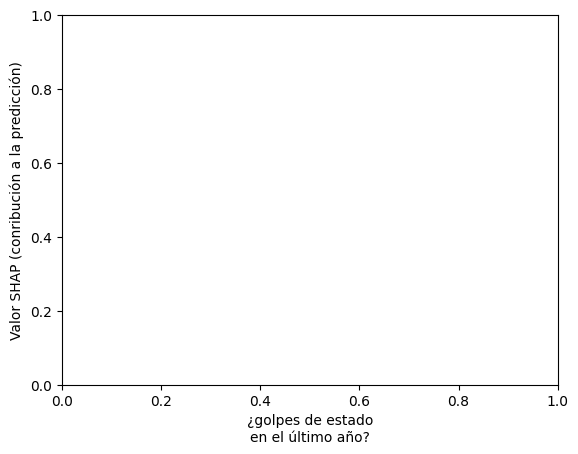

<Figure size 640x480 with 0 Axes>

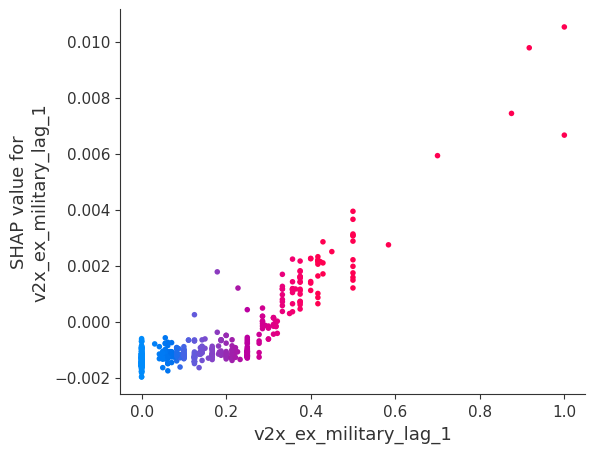

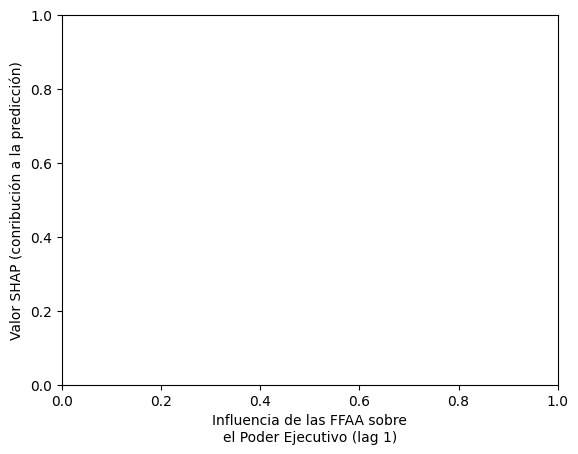

<Figure size 640x480 with 0 Axes>

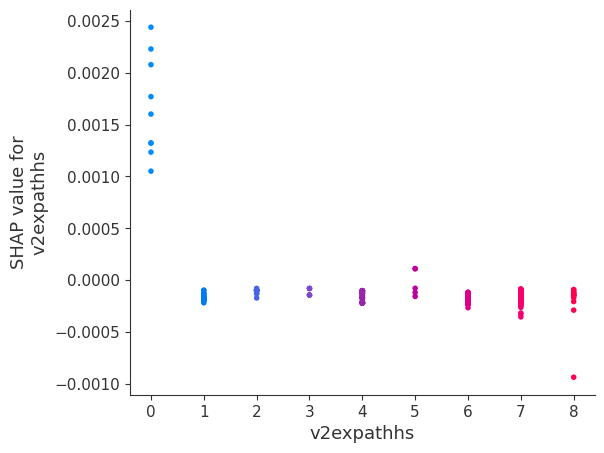

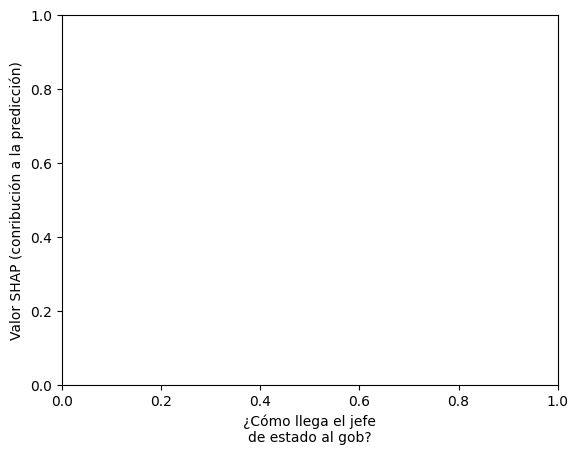

<Figure size 640x480 with 0 Axes>

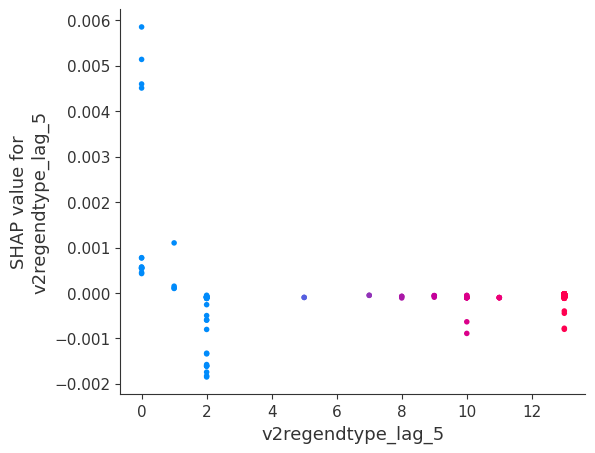

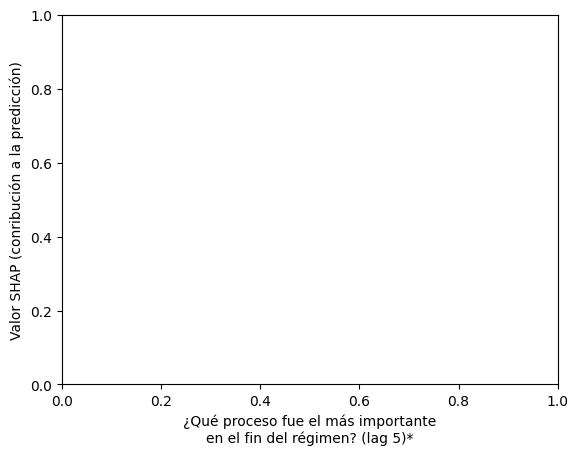

<Figure size 640x480 with 0 Axes>

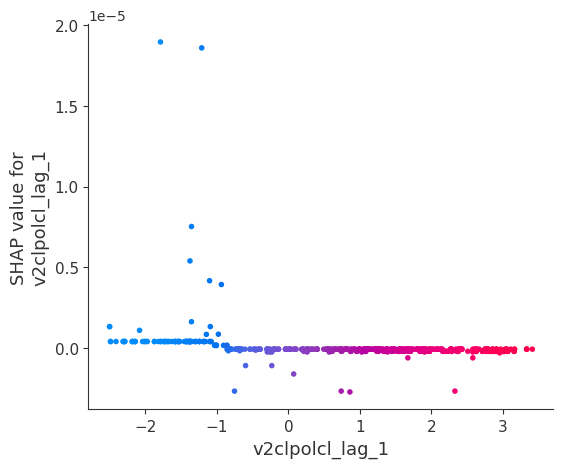

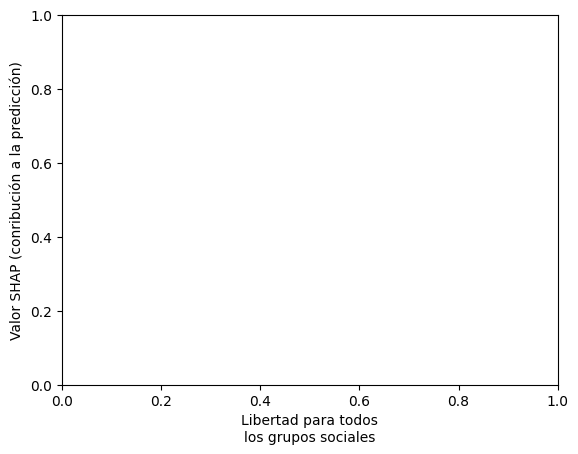

<Figure size 640x480 with 0 Axes>

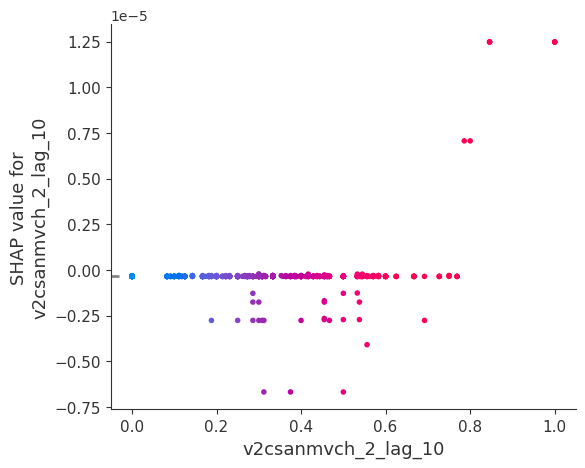

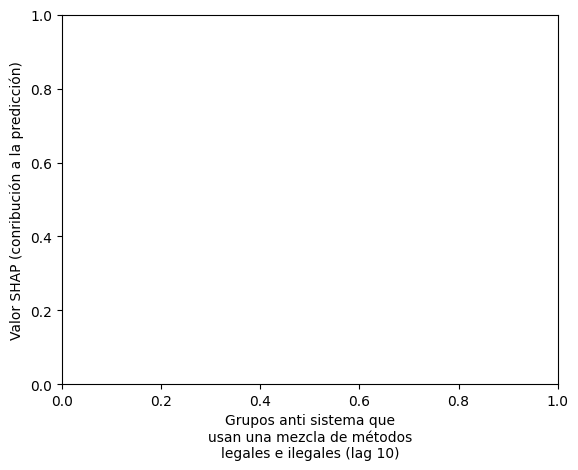

<Figure size 640x480 with 0 Axes>

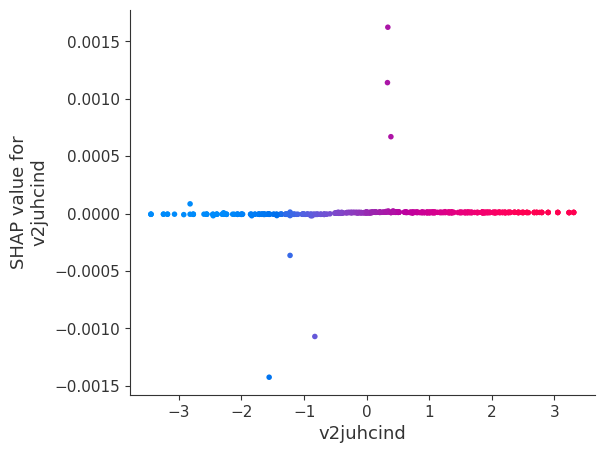

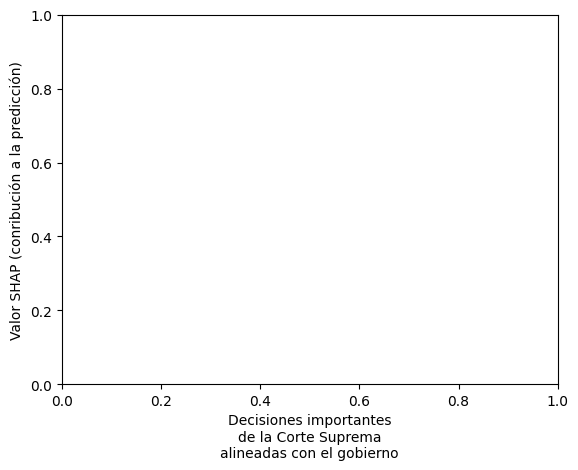

<Figure size 640x480 with 0 Axes>

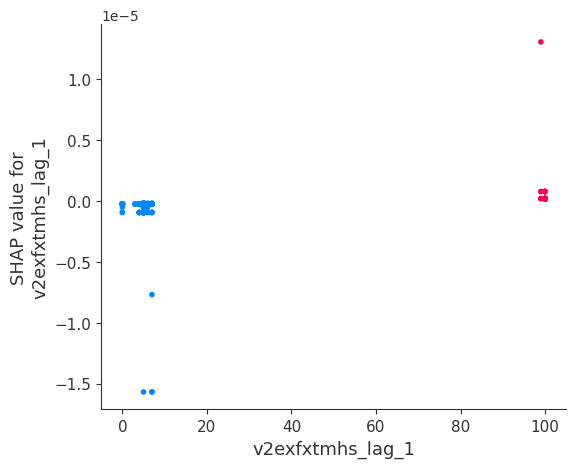

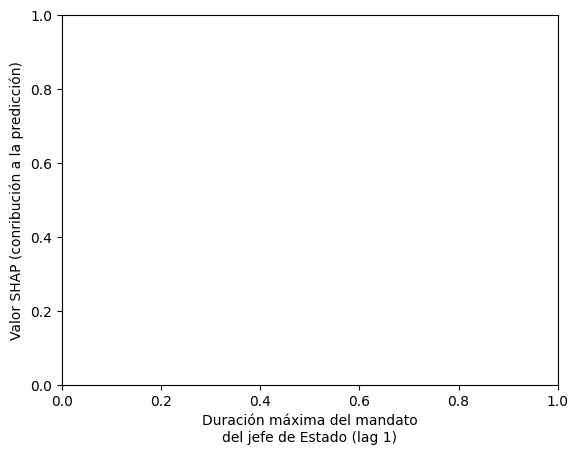

<Figure size 640x480 with 0 Axes>

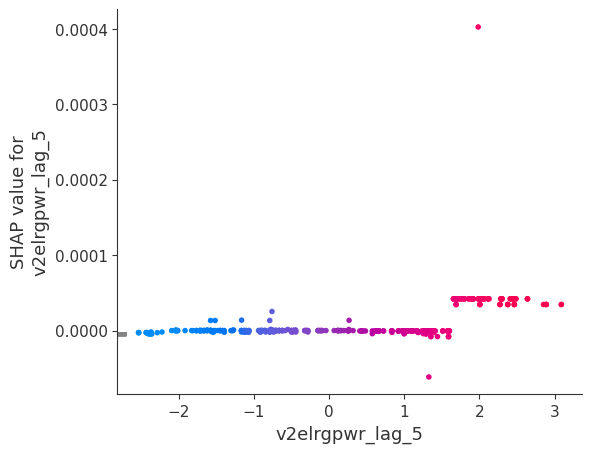

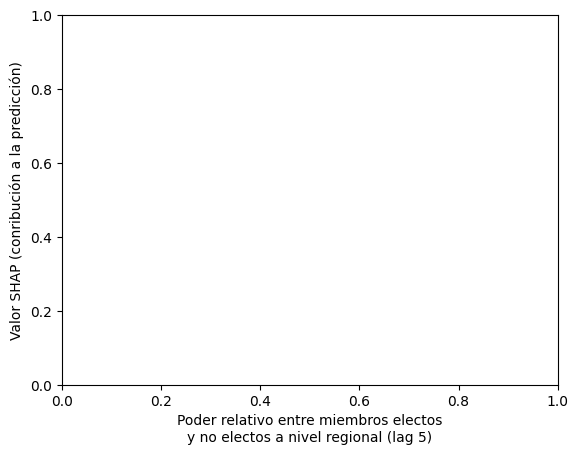

<Figure size 640x480 with 0 Axes>

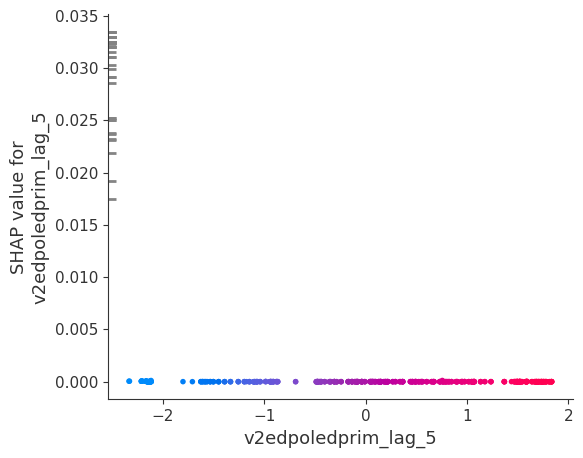

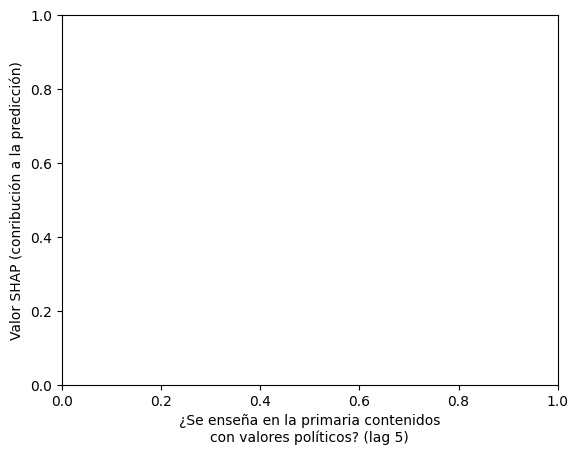

<Figure size 640x480 with 0 Axes>

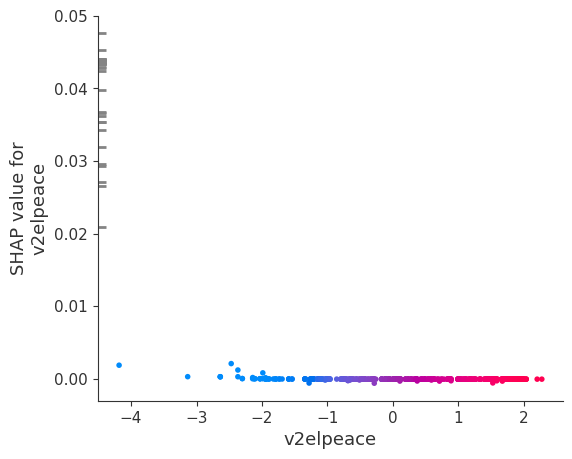

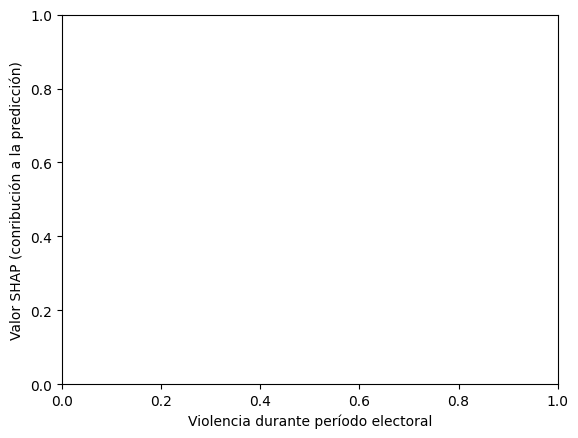

<Figure size 640x480 with 0 Axes>

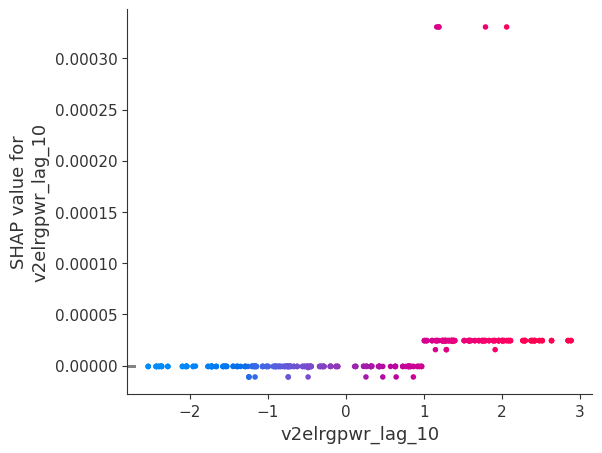

In [153]:
for feat in feat_imp_labs.keys():
    fig = plt.figure()
    shap.dependence_plot(feat,shap_values_rf[:,:,1],X_test,interaction_index=feat)
    plt.ylabel('Valor SHAP (conribución a la predicción)')
    plt.xlabel(feat_imp_labs[feat])